In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv('../data/df_model.csv')
df.head()

,age,sex,bmi,children,smoker,region,logcharges,age_x_smoker,bmi_x_smoker
0,19,1,27.900,0,1,southwest,9.734176,19,27.9
1,18,0,33.770,1,0,southeast,7.453302,0,0.0
2,28,0,33.000,3,0,southeast,8.400538,0,0.0
3,33,0,22.705,0,0,northwest,9.998092,0,0.0
4,32,0,28.880,0,0,northwest,8.260197,0,0.0


In [3]:
#train test split
X = df.drop('logcharges', axis=1)
y = df['logcharges']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [4]:
#Encoding (after splitting to prevent data leakage)

ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X_train[['region']])
X_train_region = ohe.transform(X_train[['region']])
X_test_region = ohe.transform(X_test[['region']])
region_cols = ohe.get_feature_names_out(['region'])


X_train_num = X_train.drop(columns=['region'])
X_test_num = X_test.drop(columns=['region'])

X_train_encoded = pd.concat(
    [
        X_train_num.reset_index(drop=True),
        pd.DataFrame(X_train_region, columns=region_cols).reset_index(drop=True)
    ],
    axis=1
)

X_test_encoded = pd.concat(
    [
        X_test_num.reset_index(drop=True),
        pd.DataFrame(X_test_region, columns=region_cols).reset_index(drop=True)
    ],
    axis=1
)


In [5]:
X_train_encoded.head()
X_train_encoded.shape

(1070, 10)

In [6]:
#Linear Regression

model = LinearRegression()
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)




In [7]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'r2 score: {r2}\nMSE: {mse}')

r2 score: 0.853688392134992
MSE: 0.13155471619617218


**We have achieved a great result. However, we have to take into account the encoding we made, creating several new columns. Therefore, making a Ridge regularization seems important to prevent potentiel overfitting**

In [8]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate


In [9]:
#Ridge Regression

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=10))
]
)

ridge_pipeline.fit(X_train_encoded, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test_encoded)


In [10]:
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f'r2 score for Ridge: {r2_ridge}\nMSE for Ridge: {mse_ridge}')

r2 score for Ridge: 0.8530216236629753
MSE for Ridge: 0.13215423484260552


After standardization, Ridge regression achieves similar performance to ordinary least squares, while providing better regularization and improved robustness to multicollinearity.

In [11]:
#CV for the Ridge model

cv_results = cross_validate(ridge_pipeline, X_train_encoded, y_train, cv=10, return_estimator=True)
cv_results['test_score'].mean()

np.float64(0.810241677013709)

While the test split R² reaches around 0.85, cross-validation provides a more conservative estimate around 0.81, indicating good generalization performance with moderate variance across folds. This loss can be explained by the 'smoker' variable, essential for the model. If its presence is more rare, the model will lose accuracy.

We may want to try non linear models to see if we can capture informations

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
RFR = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

RFR.fit(X_train_encoded, y_train)
y_pred_rfr = RFR.predict(X_test_encoded)

r2_rfr = r2_score(y_test, y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)

print(f'r2 score for Random Forest Regressor: {r2_rfr}\nMSE for Random Forest Regressor: {mse_rfr}')

r2 score for Random Forest Regressor: 0.8564802249450878
MSE for Random Forest Regressor: 0.12904446579048892


In [14]:
#CV for the RFR model

cv_results_rfr = cross_validate(RFR, X_train_encoded, y_train, cv=10, return_estimator=True)
cv_results_rfr['test_score'].mean()

np.float64(0.8096748898833575)

In [15]:
#Polynomial features for the ridge regression (best model so far)
from sklearn.preprocessing import PolynomialFeatures

In [16]:
pipeline_ridge_poly = Pipeline([
    ('polynomial', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=10))
]
)

pipeline_ridge_poly.fit(X_train_encoded, y_train)
y_pred_ridge_poly = pipeline_ridge_poly.predict(X_test_encoded)


r2_poly_ridge = r2_score(y_test, y_pred_ridge_poly)
mse_poly_ridge = mean_squared_error(y_test, y_pred_ridge_poly)

print(f'r2 score for Random Forest Regressor: {r2_rfr}\nMSE for Random Forest Regressor: {mse_rfr}')

r2 score for Random Forest Regressor: 0.8564802249450878
MSE for Random Forest Regressor: 0.12904446579048892


In [17]:
cv_results = cross_validate(
    pipeline_ridge_poly,
    X_train_encoded,
    y_train,
    cv=10,
    scoring=['r2', 'neg_mean_squared_error']
)

print(f'R2: {cv_results['test_r2'].mean()}')
print(f'Dispersion: {cv_results['test_r2'].std()}')
print(f'MSE: {-cv_results['test_neg_mean_squared_error'].mean()}')


R2: 0.8230716392108473
Dispersion: 0.03789704563191655
MSE: 0.14512163622358074


Introducing second-degree polynomial features combined with Ridge regularization slightly improves cross-validated performance, indicating the presence of mild non-linear effects while maintaining model stability and interpretability.

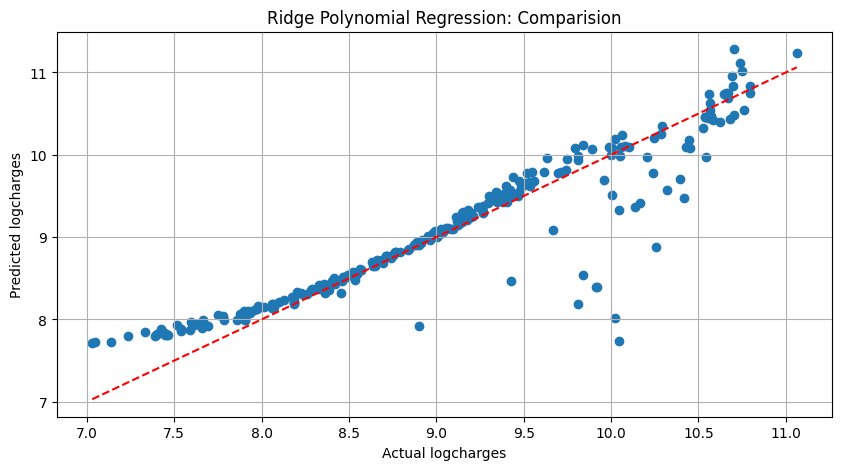

In [ ]:
#Visualiazing the model
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
ax.set_xlabel('Actual logcharges')
ax.set_ylabel('Predicted logcharges')
ax.set_title('Ridge Polynomial Regression: Comparision')
ax.grid(True)